In [1]:
# Importando bibliotecas

import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
!pip install pingouin
import pingouin as pg
from scipy import stats
from scipy.stats import norm
from scipy.stats import pearsonr
from scipy.stats import zscore
from sklearn.preprocessing import PowerTransformer
!pip install statstests
from statstests.process import stepwise
from statstests.tests import shapiro_francia
from statsmodels.iolib.summary2 import summary_col
import numpy as np

In [2]:
# Coletando nomes dos arquivos .csv em uma lista

lista_arquivos = glob.glob("Data/*.csv")

In [3]:
# Função para processar a concatenação dos arquivos

def processar_arquivos_csv(lista_arquivos):

    dataframes = []

    for arquivo in lista_arquivos:


        df = pd.read_csv(arquivo, sep=';')

        dataframes.append(df)

    df_final = pd.concat(dataframes, ignore_index=True)

    df_final = df_final.reset_index(drop=True)

    return df_final

In [4]:
# Aplicando a função

df = processar_arquivos_csv(lista_arquivos)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181896 entries, 0 to 181895
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Data                  181896 non-null  object
 1   Hora (UTC)            181896 non-null  int64 
 2   Temp. Ins. (C)        164290 non-null  object
 3   Temp. Max. (C)        163912 non-null  object
 4   Temp. Min. (C)        163911 non-null  object
 5   Umi. Ins. (%)         157432 non-null  object
 6   Umi. Max. (%)         156772 non-null  object
 7   Umi. Min. (%)         156772 non-null  object
 8   Pto Orvalho Ins. (C)  157433 non-null  object
 9   Pto Orvalho Max. (C)  156744 non-null  object
 10  Pto Orvalho Min. (C)  156744 non-null  object
 11  Pressao Ins. (hPa)    164162 non-null  object
 12  Pressao Max. (hPa)    163874 non-null  object
 13  Pressao Min. (hPa)    163874 non-null  object
 14  Vel. Vento (m/s)      163829 non-null  object
 15  Dir. Vento (m/s) 

In [5]:
# Tratamento das variáveis para alteração dos tipos

df['Data'] = pd.to_datetime(df['Data'], format='%d/%m/%Y', errors='coerce')
df['Hora (UTC)'] = df['Hora (UTC)'].astype('Int64')
df['Temp. Ins. (C)'] = df['Temp. Ins. (C)'].str.replace(',', '.').astype(float)
df['Temp. Max. (C)'] = df['Temp. Max. (C)'].str.replace(',', '.').astype(float)
df['Temp. Min. (C)'] = df['Temp. Min. (C)'].str.replace(',', '.').astype(float)
df['Umi. Ins. (%)'] = df['Umi. Ins. (%)'].str.replace(',', '.').astype(float)
df['Umi. Max. (%)'] = df['Umi. Max. (%)'].str.replace(',', '.').astype(float)
df['Umi. Min. (%)'] = df['Umi. Min. (%)'].str.replace(',', '.').astype(float)
df['Pto Orvalho Ins. (C)'] = df['Pto Orvalho Ins. (C)'].str.replace(',', '.').astype(float)
df['Pto Orvalho Max. (C)'] = df['Pto Orvalho Max. (C)'].str.replace(',', '.').astype(float)
df['Pto Orvalho Min. (C)'] = df['Pto Orvalho Min. (C)'].str.replace(',', '.').astype(float)
df['Pressao Ins. (hPa)'] = df['Pressao Ins. (hPa)'].str.replace(',', '.').astype(float)
df['Pressao Max. (hPa)'] = df['Pressao Max. (hPa)'].str.replace(',', '.').astype(float)
df['Pressao Min. (hPa)'] = df['Pressao Min. (hPa)'].str.replace(',', '.').astype(float)
df['Vel. Vento (m/s)'] = df['Vel. Vento (m/s)'].str.replace(',', '.').astype(float)
df['Dir. Vento (m/s)'] = df['Dir. Vento (m/s)'].str.replace(',', '.').astype(float)
df['Raj. Vento (m/s)'] = df['Raj. Vento (m/s)'].str.replace(',', '.').astype(float)
df['Radiacao (KJ/m²)'] = df['Radiacao (KJ/m²)'].str.replace(',', '.').astype(float)
df['Chuva (mm)'] = df['Chuva (mm)'].str.replace(',', '.').astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181896 entries, 0 to 181895
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Data                  181896 non-null  datetime64[ns]
 1   Hora (UTC)            181896 non-null  Int64         
 2   Temp. Ins. (C)        164290 non-null  float64       
 3   Temp. Max. (C)        163912 non-null  float64       
 4   Temp. Min. (C)        163911 non-null  float64       
 5   Umi. Ins. (%)         157432 non-null  float64       
 6   Umi. Max. (%)         156772 non-null  float64       
 7   Umi. Min. (%)         156772 non-null  float64       
 8   Pto Orvalho Ins. (C)  157433 non-null  float64       
 9   Pto Orvalho Max. (C)  156744 non-null  float64       
 10  Pto Orvalho Min. (C)  156744 non-null  float64       
 11  Pressao Ins. (hPa)    164162 non-null  float64       
 12  Pressao Max. (hPa)    163874 non-null  float64       
 13 

In [6]:
# Tratamento das variáveis para organizar o dataframe com uma data por observação, tendo em vista que os dados foram fornecidos com informações diárias e por hora.
# Serão estraídos os valores médios diários para cada variável, com exceção da Chuva (mm), na qual será calculada a soma diária.
# Todas as variáveis calculadas terão arredondamento de 1 casa decimal, para guardar equivalência com o dataframe original.

colunas_temperatura = ['Temp. Min. (C)', 'Temp. Max. (C)']
colunas_umidade = ['Umi. Min. (%)', 'Umi. Max. (%)']
colunas_pressao = ['Pressao Min. (hPa)', 'Pressao Max. (hPa)']

def media_min_max(grupo, colunas):
    return grupo[colunas].mean(axis=1).mean()

df_diario = df.groupby(df['Data'].dt.date).agg({
    'Chuva (mm)': 'sum',
    'Radiacao (KJ/m²)': 'mean',
    'Vel. Vento (m/s)': 'mean',
    'Dir. Vento (m/s)': 'mean',
    'Raj. Vento (m/s)': 'mean'
})

df_diario['Temp Media (C)'] = df.groupby(df['Data'].dt.date).apply(
    lambda g: media_min_max(g, colunas_temperatura)
)
df_diario['Umi Media (%)'] = df.groupby(df['Data'].dt.date).apply(
    lambda g: media_min_max(g, colunas_umidade)
)
df_diario['Pressao Media (hPa)'] = df.groupby(df['Data'].dt.date).apply(
    lambda g: media_min_max(g, colunas_pressao)
)

df_diario = df_diario.round(1)

df_diario = df_diario.reset_index()

df_diario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7579 entries, 0 to 7578
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Data                 7579 non-null   object 
 1   Chuva (mm)           7579 non-null   float64
 2   Radiacao (KJ/m²)     6940 non-null   float64
 3   Vel. Vento (m/s)     6954 non-null   float64
 4   Dir. Vento (m/s)     6954 non-null   float64
 5   Raj. Vento (m/s)     6953 non-null   float64
 6   Temp Media (C)       6956 non-null   float64
 7   Umi Media (%)        6944 non-null   float64
 8   Pressao Media (hPa)  6954 non-null   float64
dtypes: float64(8), object(1)
memory usage: 533.0+ KB


In [7]:
df_diario.head()

Data  Chuva (mm)  Radiacao (KJ/m²)  Vel. Vento (m/s)  \
0  2004-01-01         7.0             543.1               1.7   
1  2004-01-02         0.0            1036.3               2.4   
2  2004-01-03         0.0            1595.1               2.5   
3  2004-01-04         0.0            1670.4               2.3   
4  2004-01-05         0.0            1791.3               2.0   

   Dir. Vento (m/s)  Raj. Vento (m/s)  Temp Media (C)  Umi Media (%)  \
0             173.3               4.9            21.7           88.5   
1             122.7               7.1            20.2           76.0   
2             114.9               7.1            20.6           71.2   
3             107.5               6.7            22.6           70.4   
4             105.8               5.4            24.0           68.9   

   Pressao Media (hPa)  
0                940.4  
1                941.2  
2                941.1  
3                940.8  
4                940.9

In [8]:
# Tendo em vista a ausência de dados, se optou pelo drop das observações que possuem variáveis nulas.

df_clean = df_diario.dropna().reset_index(drop=True)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6926 entries, 0 to 6925
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Data                 6926 non-null   object 
 1   Chuva (mm)           6926 non-null   float64
 2   Radiacao (KJ/m²)     6926 non-null   float64
 3   Vel. Vento (m/s)     6926 non-null   float64
 4   Dir. Vento (m/s)     6926 non-null   float64
 5   Raj. Vento (m/s)     6926 non-null   float64
 6   Temp Media (C)       6926 non-null   float64
 7   Umi Media (%)        6926 non-null   float64
 8   Pressao Media (hPa)  6926 non-null   float64
dtypes: float64(8), object(1)
memory usage: 487.1+ KB


In [12]:
estatisticas = df_clean.describe()
estatisticas

Chuva (mm)  Radiacao (KJ/m²)  Vel. Vento (m/s)  Dir. Vento (m/s)  \
count  6926.000000       6926.000000       6926.000000       6926.000000   
mean      3.219463       1248.225152          1.338406        163.508013   
std       9.169697        433.790028          0.657810         62.211395   
min       0.000000          3.000000          0.000000         39.400000   
25%       0.000000        936.650000          1.000000        114.800000   
50%       0.000000       1288.900000          1.400000        145.100000   
75%       0.800000       1564.850000          1.800000        208.000000   
max     134.400000       3141.400000          3.500000        350.300000   

       Raj. Vento (m/s)  Temp Media (C)  Umi Media (%)  Pressao Media (hPa)  
count       6926.000000     6926.000000    6926.000000          6926.000000  
mean           4.448094       21.900606      70.441886           943.257696  
std            1.850983        3.242254      12.940920             3.265015  
min            0.000000        8.600000      23.800000           932.200000  
25%            3.600000       19.900000      62.400000           941.000000  
50%            4.500000       22.200000      71.500000           943.000000  
75%            5.500000       24.100000      79.675000           945.500000  
max           11.800000       32.100000     100.000000           954.500000

In [13]:
df_clean['Data'] = pd.to_datetime(df_clean['Data'], format='%d/%m/%Y', errors='coerce')

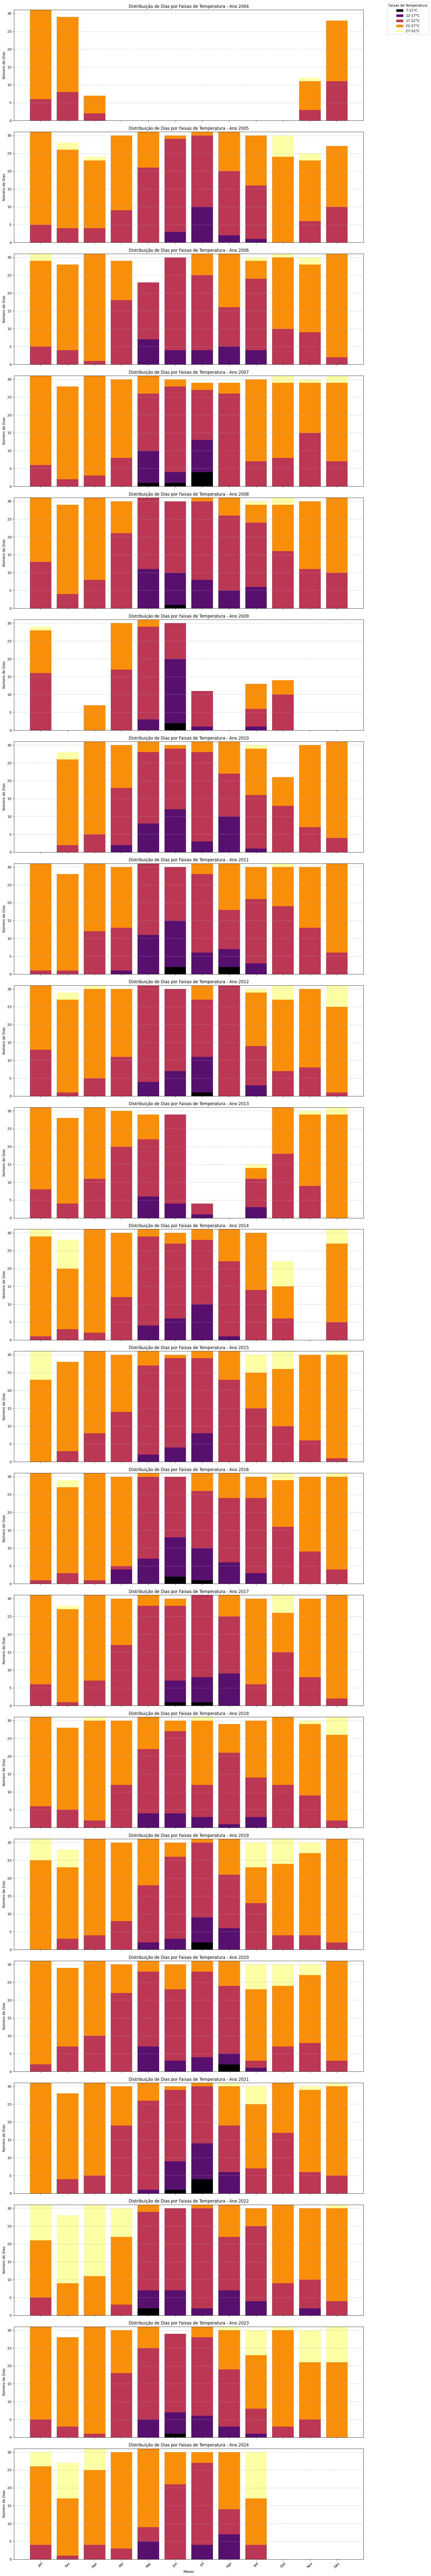

In [14]:
# Criação de gráfico de barras empilhadas, por mês e ano, para a contagem de dias em relação à temperatura média calculada. As temperaturas foram dividas em faixas de 5 graus, a partir da primeira temperatura verificada.

# 1. Criação das faixas de temperatura (5 em 5 graus)
bins = range(int(df_clean['Temp Media (C)'].min()) - 1,
             int(df_clean['Temp Media (C)'].max()) + 5, 5)
labels = [f'{i}-{i + 5}°C' for i in bins[:-1]]

# 2. Adiciona a coluna de faixa de temperatura ao DataFrame
df_clean['Faixa_Temp'] = pd.cut(df_clean['Temp Media (C)'], bins=bins, labels=labels, right=False)

# 3. Cria coluna auxiliar para Ano e Mês
df_clean['Ano'] = df_clean['Data'].dt.year
df_clean['Mes'] = df_clean['Data'].dt.month

# 4. Agrupa os dados por Ano, Mês e Faixa de Temperatura
dados_agrupados = df_clean.groupby(['Ano', 'Mes', 'Faixa_Temp']).size().unstack(fill_value=0)

# 5. Gera gráficos para cada ano
anos = dados_agrupados.index.levels[0]  # Obtemos os anos únicos

# 6. Configuração do gráfico
fig, axs = plt.subplots(nrows=len(anos), figsize=(15, 5 * len(anos)), sharex=True)

# 7. Gera as cores usando o colormap 'inferno'
colormap = plt.get_cmap('inferno')  # Escolhendo colormap
norm = plt.Normalize(vmin=0, vmax=len(labels) - 1)  # Normaliza as cores
cores = [colormap(norm(i)) for i in range(len(labels))]

# 8. Plotando barras empilhadas para cada ano
for i, ano in enumerate(anos):
    ax = axs[i]
    dados_ano = dados_agrupados.loc[ano]  # Filtra os dados para o ano atual
    bottom = [0] * len(dados_ano)  # Inicializa o fundo das barras

    for j, (faixa, cor) in enumerate(zip(dados_ano.columns, cores)):
        ax.bar(
            dados_ano.index,
            dados_ano[faixa],
            label=faixa if i == 0 else "",  # Apenas no primeiro gráfico
            color=cor,
            bottom=bottom
        )
        bottom += dados_ano[faixa]  # Atualiza o fundo da barra

    # 8.1 Personalizações do gráfico
    ax.set_title(f'Distribuição de Dias por Faixas de Temperatura - Ano {ano}')
    ax.set_ylabel('Número de Dias')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# 9. Configuração do eixo X
axs[-1].set_xlabel('Meses')
axs[-1].set_xticks(range(1, 13))
axs[-1].set_xticklabels(['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun',
                         'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'], rotation=45)

# 10. Adiciona a legenda fora do gráfico, apenas uma vez
handles = [plt.Rectangle((0,0),1,1, color=cores[i]) for i in range(len(labels))]
fig.legend(handles, labels, title='Faixas de Temperatura', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [15]:
# Definindo nova ordem das colunas
nova_ordem = ['Data', 'Temp Media (C)', 'Chuva (mm)', 'Radiacao (KJ/m²)',
              'Vel. Vento (m/s)', 'Dir. Vento (m/s)', 'Raj. Vento (m/s)',
              'Umi Media (%)', 'Pressao Media (hPa)']

# Reordenando o DataFrame
df_reordenado = df_clean[nova_ordem]

In [16]:
df_reordenado = df_reordenado.sort_values(by='Data', ascending=True)
df_reordenado = df_reordenado.rename(columns={
    'Temp Media (C)': 'Temp_Media',
    'Chuva (mm)': 'Precipitacao',
    'Radiacao (KJ/m²)': 'Radiacao',
    'Vel. Vento (m/s)': 'Vel_Vento',
    'Dir. Vento (m/s)': 'Dir_Vento',
    'Raj. Vento (m/s)': 'Raj_Vento',
    'Umi Media (%)': 'Umi_Media',
    'Pressao Media (hPa)': 'Pressao_Media'
})
df_reordenado['Data'] = pd.to_datetime(df_reordenado['Data'], format='%d/%m/%Y', errors='coerce')
df_reordenado

Data  Temp_Media  Precipitacao  Radiacao  Vel_Vento  Dir_Vento  \
0    2004-01-01        21.7           7.0     543.1        1.7      173.3   
1    2004-01-02        20.2           0.0    1036.3        2.4      122.7   
2    2004-01-03        20.6           0.0    1595.1        2.5      114.9   
3    2004-01-04        22.6           0.0    1670.4        2.3      107.5   
4    2004-01-05        24.0           0.0    1791.3        2.0      105.8   
...         ...         ...           ...       ...        ...        ...   
6921 2024-09-26        31.1           0.0    1371.6        1.9      166.9   
6922 2024-09-27        26.8           0.0    1003.1        3.0      197.2   
6923 2024-09-28        23.0           0.0    1394.3        2.4      122.6   
6924 2024-09-29        23.2           0.0    1505.1        2.1      126.4   
6925 2024-09-30        26.4           0.0    1412.3        2.0      103.3   

      Raj_Vento  Umi_Media  Pressao_Media  
0           4.9       88.5          940.4  
1           7.1       76.0          941.2  
2           7.1       71.2          941.1  
3           6.7       70.4          940.8  
4           5.4       68.9          940.9  
...         ...        ...            ...  
6921        5.6       25.9          939.6  
6922        7.6       51.4          940.7  
6923        8.1       55.1          943.5  
6924        6.5       49.9          944.3  
6925        6.5       48.3          943.2  

[6926 rows x 9 columns]

In [17]:
df_reordenado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6926 entries, 0 to 6925
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Data           6926 non-null   datetime64[ns]
 1   Temp_Media     6926 non-null   float64       
 2   Precipitacao   6926 non-null   float64       
 3   Radiacao       6926 non-null   float64       
 4   Vel_Vento      6926 non-null   float64       
 5   Dir_Vento      6926 non-null   float64       
 6   Raj_Vento      6926 non-null   float64       
 7   Umi_Media      6926 non-null   float64       
 8   Pressao_Media  6926 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 487.1 KB


In [18]:
# Colocando a data como index

df_reordenado = df_reordenado.set_index('Data')
df_reordenado

Temp_Media  Precipitacao  Radiacao  Vel_Vento  Dir_Vento  \
Data                                                                   
2004-01-01        21.7           7.0     543.1        1.7      173.3   
2004-01-02        20.2           0.0    1036.3        2.4      122.7   
2004-01-03        20.6           0.0    1595.1        2.5      114.9   
2004-01-04        22.6           0.0    1670.4        2.3      107.5   
2004-01-05        24.0           0.0    1791.3        2.0      105.8   
...                ...           ...       ...        ...        ...   
2024-09-26        31.1           0.0    1371.6        1.9      166.9   
2024-09-27        26.8           0.0    1003.1        3.0      197.2   
2024-09-28        23.0           0.0    1394.3        2.4      122.6   
2024-09-29        23.2           0.0    1505.1        2.1      126.4   
2024-09-30        26.4           0.0    1412.3        2.0      103.3   

            Raj_Vento  Umi_Media  Pressao_Media  
Data                                             
2004-01-01        4.9       88.5          940.4  
2004-01-02        7.1       76.0          941.2  
2004-01-03        7.1       71.2          941.1  
2004-01-04        6.7       70.4          940.8  
2004-01-05        5.4       68.9          940.9  
...               ...        ...            ...  
2024-09-26        5.6       25.9          939.6  
2024-09-27        7.6       51.4          940.7  
2024-09-28        8.1       55.1          943.5  
2024-09-29        6.5       49.9          944.3  
2024-09-30        6.5       48.3          943.2  

[6926 rows x 8 columns]

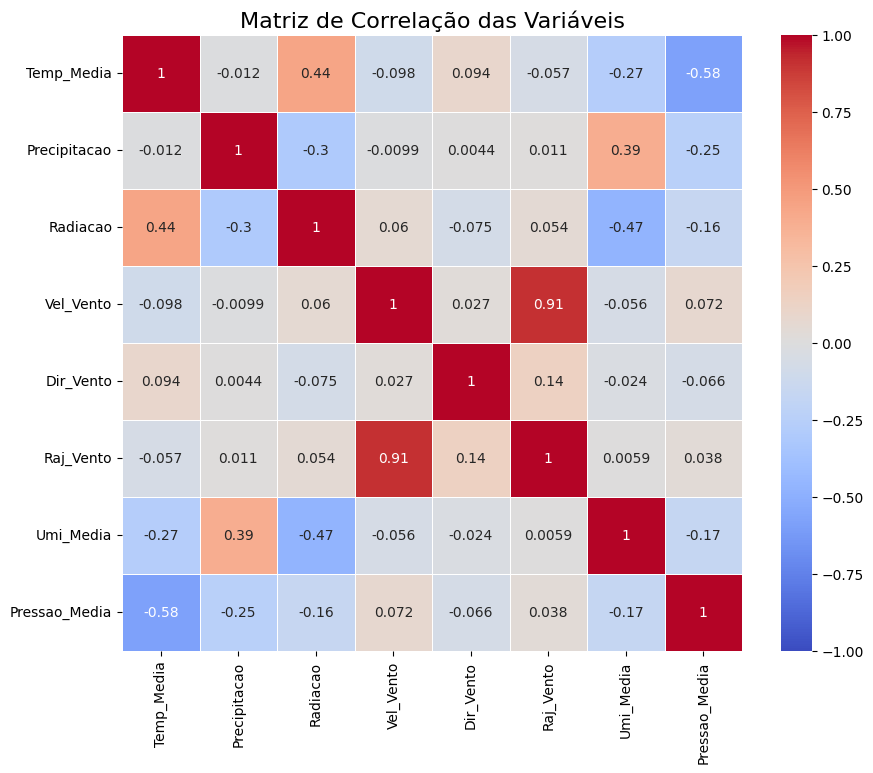

In [19]:
# Verificando as correlações entre as variáveis

correlation_matrix = df_reordenado.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)

plt.title('Matriz de Correlação das Variáveis', fontsize=16)

plt.show()

In [20]:
# Verificando a correlação de outra forma

correlation_matrix2 = pg.rcorr(df_reordenado, method='pearson',
                               upper='pval', decimals=6,
                               pval_stars={0.01: '***',
                                           0.05: '**',
                                           0.10: '*'})
correlation_matrix2

Temp_Media Precipitacao   Radiacao  Vel_Vento  Dir_Vento  \
Temp_Media             -                     ***        ***        ***   
Precipitacao    -0.01183            -        ***                         
Radiacao        0.439736    -0.297187          -        ***        ***   
Vel_Vento      -0.098417    -0.009928   0.060068          -         **   
Dir_Vento       0.093579     0.004382  -0.075096    0.02672          -   
Raj_Vento      -0.057034     0.011203   0.054289     0.9089   0.140974   
Umi_Media      -0.272668     0.394313  -0.474214  -0.055966  -0.024308   
Pressao_Media   -0.57979    -0.249495  -0.162823   0.071547   -0.06613   

              Raj_Vento  Umi_Media Pressao_Media  
Temp_Media          ***        ***           ***  
Precipitacao                   ***           ***  
Radiacao            ***        ***           ***  
Vel_Vento           ***        ***           ***  
Dir_Vento           ***         **           ***  
Raj_Vento             -                      ***  
Umi_Media      0.005949          -           ***  
Pressao_Media  0.037883  -0.171446             -

<Figure size 2000x1000 with 0 Axes>

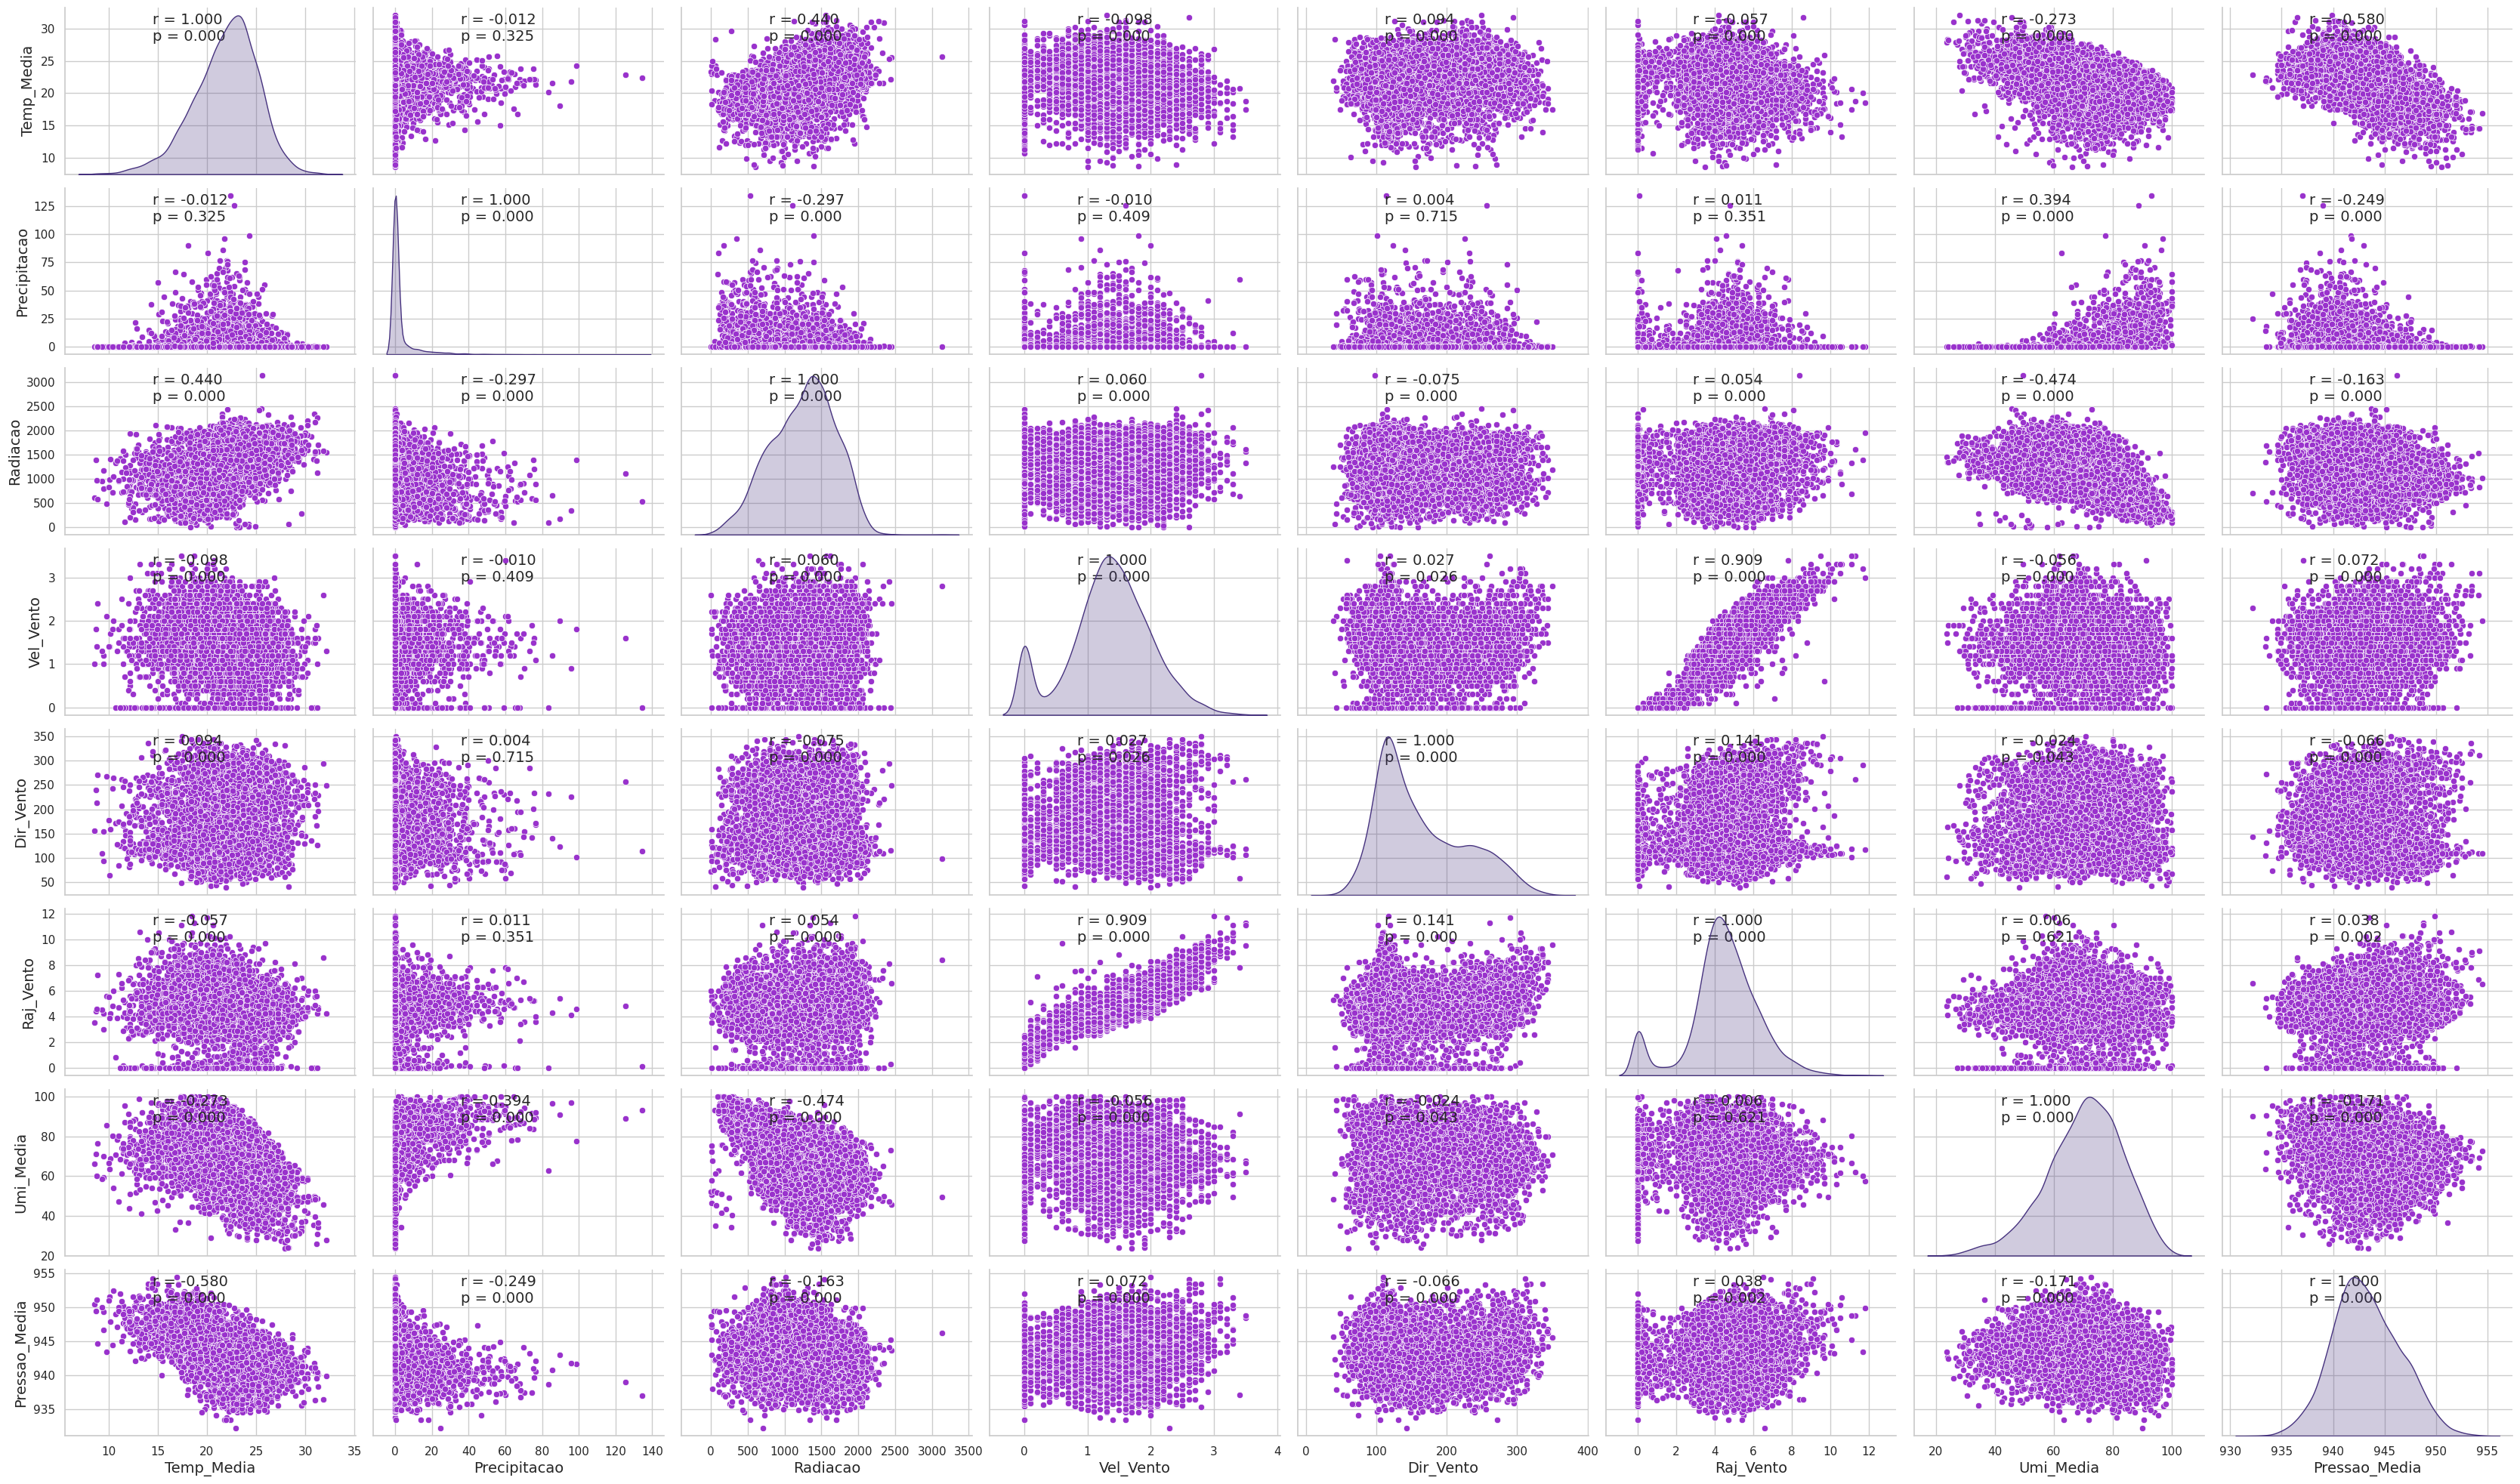

In [21]:
# Gráfico com distribuições das variáveis, scatters, valores das correlações e respectivas significâncias estatísticas

def corrfunc(x, y, **kws):
    (r, p) = pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.3f}".format(r),
                xy=(.30, .9), xycoords=ax.transAxes, fontsize=14)
    ax.annotate("p = {:.3f}".format(p),
                xy=(.30, .8), xycoords=ax.transAxes, fontsize=14)

sns.set(style="whitegrid", palette="viridis")

plt.figure(figsize=(20,10))
graph = sns.pairplot(df_reordenado, diag_kind="kde", plot_kws={"color": "darkorchid"},
                     height=2.5, aspect=1.7)
graph.map(corrfunc)
for ax in graph.axes.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=14)
    ax.set_ylabel(ax.get_ylabel(), fontsize=14)
plt.show()

In [22]:
# Aplicando a transformação z-score por conta das diferentes amplitudes das variáveis

df_normalizado = df_reordenado.apply(zscore)
df_normalizado

Temp_Media  Precipitacao  Radiacao  Vel_Vento  Dir_Vento  \
Data                                                                   
2004-01-01   -0.061877      0.412316 -1.625616   0.549733   0.157410   
2004-01-02   -0.524552     -0.351123 -0.488578   1.613947  -0.656005   
2004-01-03   -0.401172     -0.351123  0.799695   1.765978  -0.781393   
2004-01-04    0.215728     -0.351123  0.973294   1.461917  -0.900350   
2004-01-05    0.647557     -0.351123  1.252021   1.005825  -0.927679   
...                ...           ...       ...        ...        ...   
2024-09-26    2.837550     -0.351123  0.284432   0.853795   0.054527   
2024-09-27    1.511216     -0.351123 -0.565119   2.526131   0.541612   
2024-09-28    0.339108     -0.351123  0.336765   1.613947  -0.657612   
2024-09-29    0.400798     -0.351123  0.592207   1.157856  -0.596526   
2024-09-30    1.387837     -0.351123  0.378263   1.005825  -0.967867   

            Raj_Vento  Umi_Media  Pressao_Media  
Data                                             
2004-01-01   0.244161   1.395528      -0.875310  
2004-01-02   1.432805   0.429530      -0.630271  
2004-01-03   1.432805   0.058587      -0.660901  
2004-01-04   1.216688  -0.003237      -0.752791  
2004-01-05   0.514308  -0.119157      -0.722161  
...               ...        ...            ...  
2024-09-26   0.622366  -3.442190      -1.120350  
2024-09-27   1.702951  -1.471554      -0.783421  
2024-09-28   1.973097  -1.185618       0.074218  
2024-09-29   1.108629  -1.587474       0.319257  
2024-09-30   1.108629  -1.711121      -0.017672  

[6926 rows x 8 columns]

In [23]:
# Criação de fórmula para aplicação no Modelo de Regressão

lista_colunas = list(df_normalizado.drop(columns=['Temp_Media']).columns)
formula = ' + '.join(lista_colunas)
formula = "Temp_Media ~ " + formula
formula

'Temp_Media ~ Precipitacao + Radiacao + Vel_Vento + Dir_Vento + Raj_Vento + Umi_Media + Pressao_Media'

In [24]:
# Aplicando o modelo de regressão múltipla

modelo_regressa_multipla = sm.OLS.from_formula(formula, df_normalizado).fit()

modelo_regressa_multipla.summary()

# Cálculo do R² ajustado
r2_ajust = 1-((len(df_normalizado.index)-1)/(len(df_normalizado.index)-modelo_regressa_multipla.params.count()))*(1-modelo_regressa_multipla.rsquared)
print(f"R² ajustado: {r2_ajust}")

R² ajustado: 0.526821158373667


In [25]:
# Teste de Shapiro-Francia para verificação da aderência dos resíduos à normalidade

teste_sf = shapiro_francia(modelo_regressa_multipla.resid)
teste_sf = teste_sf.items()
method, statistics_W, statistics_z, p = teste_sf
print('Statistics W=%.5f, p-value=%.6f' % (statistics_W[1], p[1]))
alpha = 0.05 #nível de significância
if p[1] > alpha:
	print('Não se rejeita H0 - Distribuição aderente à normalidade')
else:
	print('Rejeita-se H0 - Distribuição não aderente à normalidade')

method  :  Shapiro-Francia normality test
statistics W  :  0.975378530840371
statistics z  :  11.830134727283786
p-value  :  1.3635186425603855e-32
Statistics W=0.97538, p-value=0.000000
Rejeita-se H0 - Distribuição não aderente à normalidade


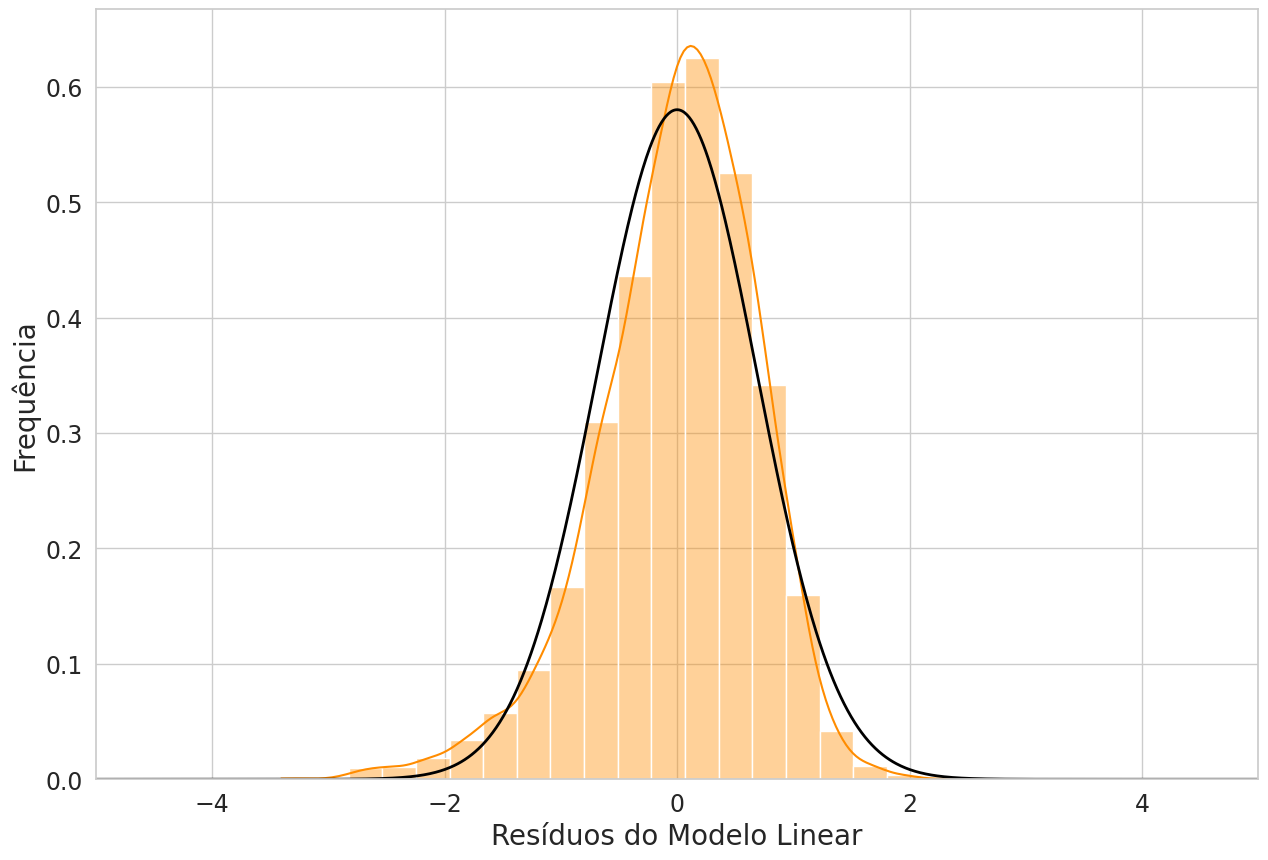

In [29]:
# Histograma dos resíduos do modelo de regressão múltipla

from scipy.stats import norm

# Calcula os valores de ajuste da distribuição normal
(mu, sigma) = norm.fit(modelo_regressa_multipla.resid)

# Gráfico propriamente dito
plt.figure(figsize=(15,10))
sns.histplot(modelo_regressa_multipla.resid, bins=20, kde=True, stat="density",
             color='darkorange', alpha=0.4)
plt.xlim(-5, 5)
x = np.linspace(-5, 5, 1000)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'k', linewidth=2)
plt.xlabel('Resíduos do Modelo Linear', fontsize=20)
plt.ylabel('Frequência', fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.show()


In [30]:
# Aplicando a transformação Yeo-Johnson (aceita valores <= 0, por conta da transformação z-score)

df_normalizado_pt = df_normalizado.copy()

pt = PowerTransformer(method='yeo-johnson')
df_normalizado_pt['pt_Temp_Media'] = pt.fit_transform(df_normalizado[['Temp_Media']])

df_normalizado_pt

Temp_Media  Precipitacao  Radiacao  Vel_Vento  Dir_Vento  \
Data                                                                   
2004-01-01   -0.061877      0.412316 -1.625616   0.549733   0.157410   
2004-01-02   -0.524552     -0.351123 -0.488578   1.613947  -0.656005   
2004-01-03   -0.401172     -0.351123  0.799695   1.765978  -0.781393   
2004-01-04    0.215728     -0.351123  0.973294   1.461917  -0.900350   
2004-01-05    0.647557     -0.351123  1.252021   1.005825  -0.927679   
...                ...           ...       ...        ...        ...   
2024-09-26    2.837550     -0.351123  0.284432   0.853795   0.054527   
2024-09-27    1.511216     -0.351123 -0.565119   2.526131   0.541612   
2024-09-28    0.339108     -0.351123  0.336765   1.613947  -0.657612   
2024-09-29    0.400798     -0.351123  0.592207   1.157856  -0.596526   
2024-09-30    1.387837     -0.351123  0.378263   1.005825  -0.967867   

            Raj_Vento  Umi_Media  Pressao_Media  pt_Temp_Media  
Data                                                            
2004-01-01   0.244161   1.395528      -0.875310      -0.153532  
2004-01-02   1.432805   0.429530      -0.630271      -0.593674  
2004-01-03   1.432805   0.058587      -0.660901      -0.480203  
2004-01-04   1.216688  -0.003237      -0.752791       0.133723  
2004-01-05   0.514308  -0.119157      -0.722161       0.614851  
...               ...        ...            ...            ...  
2024-09-26   0.622366  -3.442190      -1.120350       3.492058  
2024-09-27   1.702951  -1.471554      -0.783421       1.674714  
2024-09-28   1.973097  -1.185618       0.074218       0.267252  
2024-09-29   1.108629  -1.587474       0.319257       0.335249  
2024-09-30   1.108629  -1.711121      -0.017672       1.516482  

[6926 rows x 9 columns]

In [31]:
# Criação de fórmula para aplicação no Modelo de Regressão

lista_colunas_pt = list(df_normalizado_pt.drop(columns=['Temp_Media', 'pt_Temp_Media']).columns)
formula_pt = ' + '.join(lista_colunas_pt)
formula_pt = "pt_Temp_Media ~ " + formula_pt
formula_pt

'pt_Temp_Media ~ Precipitacao + Radiacao + Vel_Vento + Dir_Vento + Raj_Vento + Umi_Media + Pressao_Media'

In [32]:
# Modelo de Regressão Múltipla na base de dados com o y alterado pea transformação Yeo-Johnson

modelo_pt = sm.OLS.from_formula(formula_pt, df_normalizado_pt).fit()

modelo_pt.summary()

r2_ajust_pt = 1-((len(df_normalizado_pt.index)-1)/(len(df_normalizado_pt.index)-modelo_pt.params.count()))*(1-modelo_pt.rsquared)
print(f"R² ajustado: {r2_ajust_pt}")

R² ajustado: 0.5306150652488897


In [33]:
# Teste de Shapiro-Francia para verificação da aderência dos resíduos à normalidade

teste_sf = shapiro_francia(modelo_pt.resid)
teste_sf = teste_sf.items()
method, statistics_W, statistics_z, p = teste_sf
print('Statistics W=%.5f, p-value=%.6f' % (statistics_W[1], p[1]))
alpha = 0.05 #nível de significância
if p[1] > alpha:
	print('Não se rejeita H0 - Distribuição aderente à normalidade')
else:
	print('Rejeita-se H0 - Distribuição não aderente à normalidade')


method  :  Shapiro-Francia normality test
statistics W  :  0.9947426426637214
statistics z  :  7.841081371014265
p-value  :  2.2334142663744014e-15
Statistics W=0.99474, p-value=0.000000
Rejeita-se H0 - Distribuição não aderente à normalidade


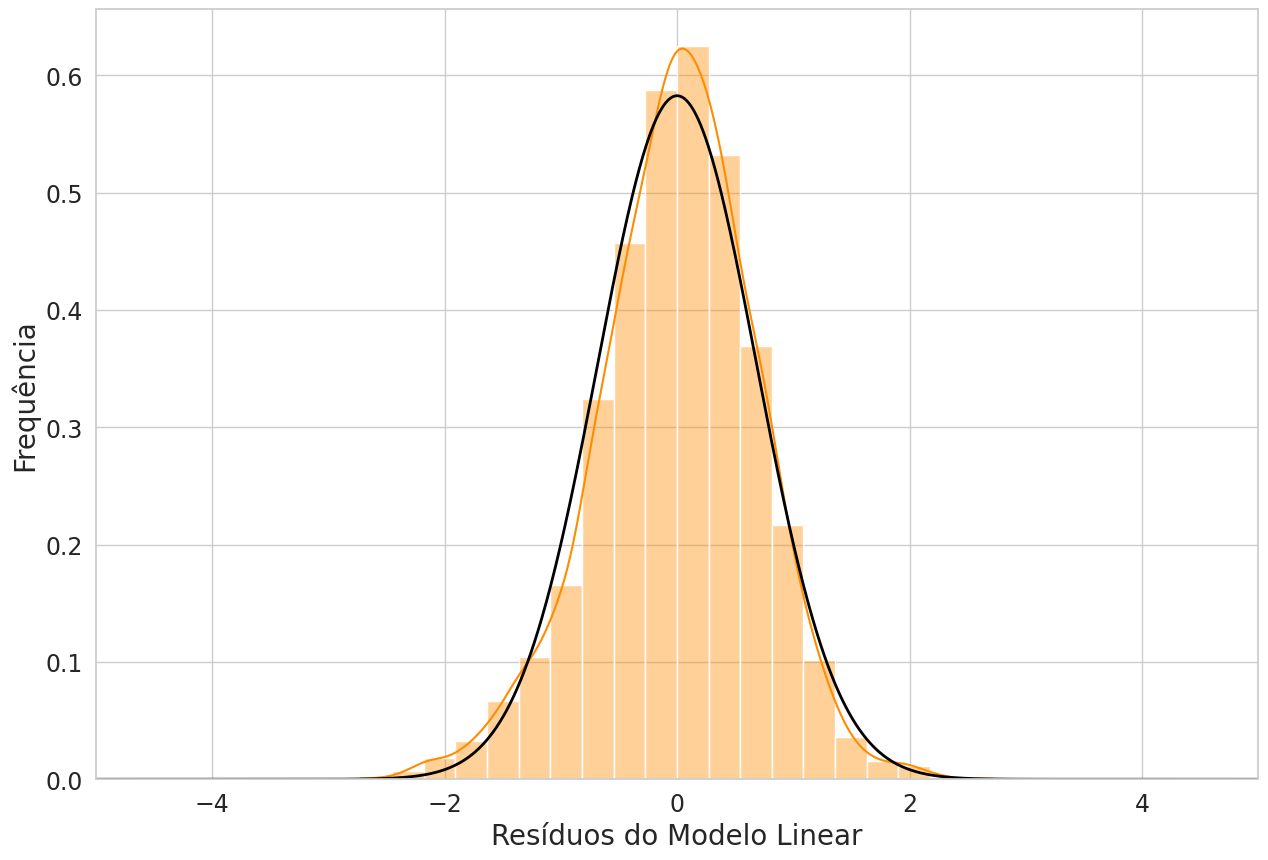

In [34]:
# Histograma dos resíduos do modelo de regressão múltipla

# Calcula os valores de ajuste da distribuição normal
(mu, sigma) = norm.fit(modelo_pt.resid)

# Gráfico propriamente dito
plt.figure(figsize=(15,10))
sns.histplot(modelo_pt.resid, bins=20, kde=True, stat="density",
             color='darkorange', alpha=0.4)
plt.xlim(-5, 5)
x = np.linspace(-5, 5, 1000)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'k', linewidth=2)
plt.xlabel('Resíduos do Modelo Linear', fontsize=20)
plt.ylabel('Frequência', fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.show()

In [35]:
# Comparando os parâmetros do 'modelo_linear' com os do 'modelo_bc'

# Comparação completa
summary_col([modelo_regressa_multipla, modelo_pt],
            model_names=["MODELO LINEAR","MODELO BOX-COX"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs))
        })


<class 'statsmodels.iolib.summary2.Summary'>
"""

===========================================
               MODELO LINEAR MODELO BOX-COX
-------------------------------------------
Intercept      -0.0000       -0.0000       
               (0.0083)      (0.0082)      
Precipitacao   0.0205**      0.0185**      
               (0.0094)      (0.0094)      
Radiacao       0.2272***     0.2331***     
               (0.0102)      (0.0101)      
Vel_Vento      -0.2281***    -0.2361***    
               (0.0208)      (0.0207)      
Dir_Vento      0.0502***     0.0579***     
               (0.0088)      (0.0087)      
Raj_Vento      0.1541***     0.1589***     
               (0.0210)      (0.0209)      
Umi_Media      -0.2836***    -0.3017***    
               (0.0103)      (0.0102)      
Pressao_Media  -0.5725***    -0.5600***    
               (0.0091)      (0.0091)      
R-squared      0.5273        0.5311        
R-squared Adj. 0.5268        0.5306        
N              6926          6926          
===========================================
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
"""

In [36]:
# Comparação somente do R²

pd.DataFrame({'R² OLS':[round(modelo_regressa_multipla.rsquared,4)],
              'R² Yeo-Johnson':[round(modelo_pt.rsquared,4)]})

R² OLS  R² Yeo-Johnson
0  0.5273          0.5311

In [37]:
# Tentativa de melhora do modelo usando o procedimento stepwise no modelo de regressão múltipla

modelo_step_regressa_multipla = stepwise(modelo_regressa_multipla, pvalue_limit=0.05)

Regression type: OLS 

Estimating model...: 
 Temp_Media ~ Q('Precipitacao') + Q('Radiacao') + Q('Vel_Vento') + Q('Dir_Vento') + Q('Raj_Vento') + Q('Umi_Media') + Q('Pressao_Media')

 No more atributes with p-value higher than 0.05

 Atributes discarded on the process...: 


 Model after stepwise process...: 
 Temp_Media ~ Q('Precipitacao') + Q('Radiacao') + Q('Vel_Vento') + Q('Dir_Vento') + Q('Raj_Vento') + Q('Umi_Media') + Q('Pressao_Media') 

                            OLS Regression Results                            
Dep. Variable:             Temp_Media   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     1102.
Date:                Wed, 30 Oct 2024   Prob (F-statistic):               0.00
Time:                        21:11:55   Log-Likelihood:                -7232.8
No. Observations:                6926   AIC:                         1.448e+

In [38]:
# Tentativa de melhora do modelo usando o procedimento stepwise no modelo de regressão múltipla com transformação de Yeo-Johnson

modelo_step_bc = stepwise(modelo_pt, pvalue_limit=0.05)

Regression type: OLS 

Estimating model...: 
 pt_Temp_Media ~ Q('Precipitacao') + Q('Radiacao') + Q('Vel_Vento') + Q('Dir_Vento') + Q('Raj_Vento') + Q('Umi_Media') + Q('Pressao_Media')

 No more atributes with p-value higher than 0.05

 Atributes discarded on the process...: 


 Model after stepwise process...: 
 pt_Temp_Media ~ Q('Precipitacao') + Q('Radiacao') + Q('Vel_Vento') + Q('Dir_Vento') + Q('Raj_Vento') + Q('Umi_Media') + Q('Pressao_Media') 

                            OLS Regression Results                            
Dep. Variable:          pt_Temp_Media   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     1119.
Date:                Wed, 30 Oct 2024   Prob (F-statistic):               0.00
Time:                        21:11:56   Log-Likelihood:                -7204.9
No. Observations:                6926   AIC:                         1

In [39]:
# Função para o teste de Breusch-Pagan para a elaboração de diagnóstico de heterocedasticidade

def breusch_pagan_test(modelo):

    df = pd.DataFrame({'yhat':modelo.fittedvalues,
                       'resid':modelo.resid})

    df['up'] = (np.square(df.resid))/np.sum(((np.square(df.resid))/df.shape[0]))

    modelo_aux = sm.OLS.from_formula('up ~ yhat', df).fit()

    anova_table = sm.stats.anova_lm(modelo_aux, typ=2)

    anova_table['sum_sq'] = anova_table['sum_sq']/2

    chisq = anova_table['sum_sq'].iloc[0]

    p_value = stats.chi2.pdf(chisq, 1)*2

    print(f"chisq: {chisq}")

    print(f"p-value: {p_value}")

    return chisq, p_value

In [40]:
# Teste de Breusch-Pagan para diagnóstico de heterocedasticidade no modelo com transformação de Yeo-Johnson

breusch_pagan_test(modelo_pt)

teste_bp = breusch_pagan_test(modelo_pt)
chisq, p = teste_bp
alpha = 0.05 #nível de significância
if p > alpha:
    print('Não se rejeita H0 - Ausência de Heterocedasticidade')
else:
	print('Rejeita-se H0 - Existência de Heterocedasticidade')

chisq: 153.73173935465496
p-value: 2.667689279235139e-35
chisq: 153.73173935465496
p-value: 2.667689279235139e-35
Rejeita-se H0 - Existência de Heterocedasticidade


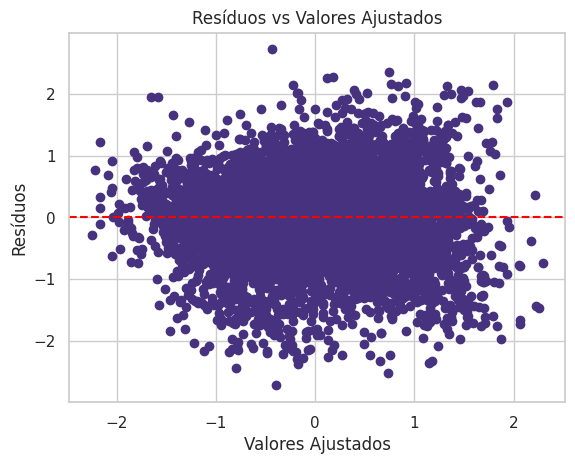

In [41]:
# Gráfico de resíduos vs valores ajustados no modelo com transformação de Yeo-Johnson
plt.scatter(modelo_pt.fittedvalues, modelo_pt.resid)
plt.xlabel('Valores Ajustados')
plt.ylabel('Resíduos')
plt.title('Resíduos vs Valores Ajustados')
plt.axhline(0, color='red', linestyle='--')
plt.show()